# Classification model for Credit Scoring

### Classification Models Applied and Compared (Supervised Learning)
- Logistic Regression
- Decision Tree
- Random Forest
- Stochastic Gradient Descent
- Extreme Gradient Boosting
- k-nearest neighbors
<br>
<br>
- Using **cross validation** to determine more accurate score which is **roc_auc**

### Content
1. Data Exploration
2. Data Clearance
3. Building and Selecting the Model
4. Performance of Model


### Goal
To create data mining model which helps to determine if a customer will be delinquent in upcoming 2 years after 90 days past.


### Given Variables
- **DelinquentMore90Days_2Yrs** Person experienced 90 days past due delinquency or worse **(Target)**

- **CreditBalanceVsCreditLimit**: Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

- **Age** Age of borrower in years

- **MonthlyIncome**: Monthly income

- **DebtRatio**: Monthly debt payments, alimony,living costs divided by monthy gross income

- **LoansAndCreditLines**: Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

- **Days30-59LateNo2Y**: Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

- **Days60-89LateNo2Y**: Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

- **Days90LateOrMore**: Number of times borrower has been 90 days or more past due.

- **RealEstateLoans**: Number of mortgage and real estate loans including home equity lines of credit

- **FamilyMembers**: Number of dependents in family excluding themselves (spouse, children etc.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from imblearn.combine import SMOTETomek 
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data.csv',index_col=0)

## 1. Data Exploration

In [3]:
df.head()

,DelinquentMore90Days_2Yrs,CreditBalanceVsCreditLimit,Age,DebtRatio,MonthlyIncome,LoansAndCreditLines,Days30-59LateNo2Y,Days60-89LateNo2Y,Days90LateOrMore,RealEstateLoans,FamilyMembers
1,1,0.766127,45,0.802982,9120.0,13,2,0,0,6,2.0
2,0,0.957151,40,0.121876,2600.0,4,0,0,0,0,1.0
3,0,0.658180,38,0.085113,3042.0,2,1,0,1,0,0.0
4,0,0.233810,30,0.036050,3300.0,5,0,0,0,0,0.0
5,0,0.907239,49,0.024926,63588.0,7,1,0,0,1,0.0


In [4]:
df.describe()

,DelinquentMore90Days_2Yrs,CreditBalanceVsCreditLimit,Age,DebtRatio,MonthlyIncome,LoansAndCreditLines,Days30-59LateNo2Y,Days60-89LateNo2Y,Days90LateOrMore,RealEstateLoans,FamilyMembers
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,353.005076,6.670221e+03,8.452760,0.421033,0.240387,0.265973,1.018240,0.757222
std,0.249746,249.755371,14.771866,2037.818523,1.438467e+04,5.145951,4.192781,4.155179,4.169304,1.129771,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.366508,5.400000e+03,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.559046,63.000000,0.868254,8.249000e+03,11.000000,0.000000,0.000000,0.000000,2.000000,1.000000
max,1.000000,50708.000000,109.000000,329664.000000,3.008750e+06,58.000000,98.000000,98.000000,98.000000,54.000000,20.000000


- MonthlyIncome has 29731 (19.82%) and NumberOfDependents has 3924 (2.61%) missing data.
- In general all variables have outliers, it can be dealt by using boxplot, z-score, inter-quartile range, or by distribution graph/ data, where can be seen a clear outliers. Some outliers are reasonable, but it is not good to use while training ml model, since it can increase models' bias
- **DelinquentMore90Days_2Yrs** clearly our target variable has majority of values 0, since mean is ~0.0668, while all quartiles equal to 0
- **CreditBalanceVsCreditLimit** have a very high max, so in order to remove outlier, quartile 95% can be taken as a filter.
- **age** has value 0, which should no exist as default when person valid to have a credit is around 18.
- **DebtRatio** clearly has very big outlier, the priority to use quartile 97.5% to remove it.
- **MonthlyIncome** cannot drop the column, since 19.82% of data is missing, can be considered for removing rows or fill with median. Dropping NaN values better to apply, since variable is reasonable and filling with to many median variables can be misleading.
- **LoansAndCreditLines** can be considered to use graph and if clear where the distribution should end, filter it, otherwise use quartile 97.5% to remove outliers.
- Values for **Days30-59LateNo2Y**, **Days60-89LateNo2Y**, **Days90LateOrMore**	have the same outliers (98). It is not possible, since for a range 30-59 cannot dropping values 98 does not seems reasonable.
- **RealEstateLoans** use graph to find possible filter or can be considered to use quartile 97.5% to remove outliers.
- **FamilyMembers** missing values can be change to 0, since the mediana is 0 and missing value can mean a 0, which by this variable is reasonable. Use graph to explore if 20 could be outlier (but everything could be).

## 2. Data Clearance

In [5]:
# Graph function to not repeat the function for every variable #
def descriptive_graph(dataset,col_name):
    plt.hist([dataset[dataset["DelinquentMore90Days_2Yrs"]==1][col_name],
                 dataset[dataset["DelinquentMore90Days_2Yrs"]==0][col_name]], bins=30, stacked=True)
    plt.legend(labels=["DelinquentMore90Days_2Yrs-1","DelinquentMore90Days_2Yrs-0"])
    plt.title(col_name)
    return plt.show()

**CreditBalanceVsCreditLimit**

In [6]:
df["CreditBalanceVsCreditLimit"].value_counts()[:5,]

0.000000    10878
1.000000    10256
1.000000       17
0.950100        8
0.713147        6
Name: CreditBalanceVsCreditLimit, dtype: int64

In [7]:
df["CreditBalanceVsCreditLimit"].quantile([.95])

0.95    1.0
Name: CreditBalanceVsCreditLimit, dtype: float64

**Age**

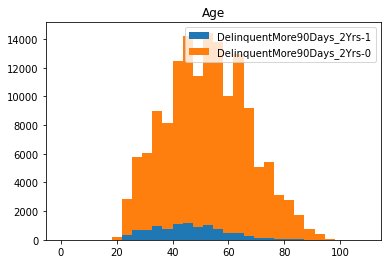

In [8]:
descriptive_graph(df,"Age")

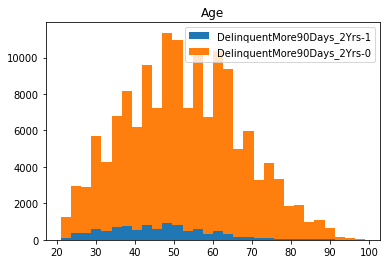

In [9]:
df = df[df["Age"] > 18]
df = df[df["Age"] < 100]
descriptive_graph(df,"Age")

**MonthlyIncome**

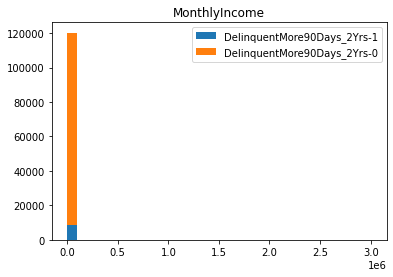

In [10]:
descriptive_graph(df,"MonthlyIncome")

In [11]:
df["MonthlyIncome"].quantile([.99])

0.99    25000.0
Name: MonthlyIncome, dtype: float64

Since this data has very big outliers, 0.01% can be removed to have better distribution. By filtering, na values will be dropped automatically

In [12]:
df = df[df["MonthlyIncome"] <= 25000]

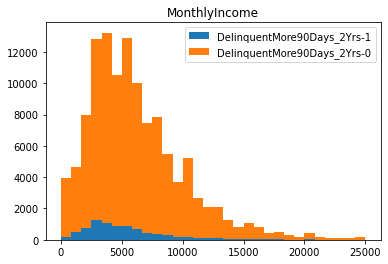

In [13]:
descriptive_graph(df,"MonthlyIncome")

Usually classification models barely handles continuous numbers with non normal distribution. Currently it is right skewed and log(x+1) can be applied to avoid -inf numbers and have normal distribution

In [14]:
df["MonthlyIncome"] = np.log(df["MonthlyIncome"]+1)

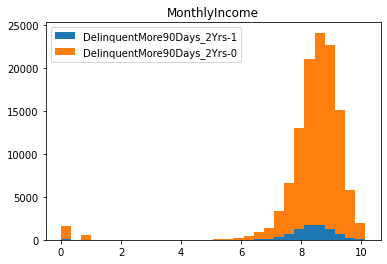

In [15]:
descriptive_graph(df,"MonthlyIncome")

In [16]:
df = df[df["MonthlyIncome"] > 7]

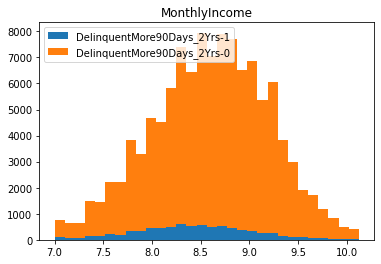

In [17]:
descriptive_graph(df,"MonthlyIncome")

**DebtRatio**

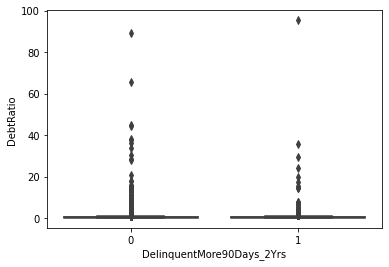

1.6107370918000001

In [18]:
sns.boxplot(x="DelinquentMore90Days_2Yrs", y="DebtRatio", data=df)
plt.show()
df["DebtRatio"].quantile(0.99)

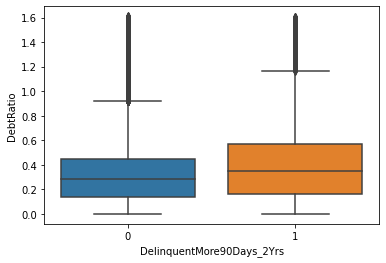

In [19]:
df = df[df["DebtRatio"] < 1.6107]
sns.boxplot(x="DelinquentMore90Days_2Yrs", y="DebtRatio", data=df)

**LoansAndCreditLines**

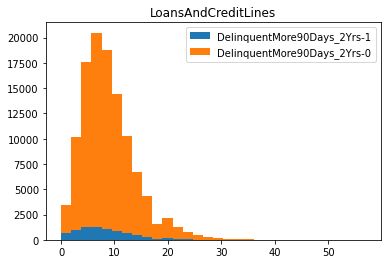

In [20]:
descriptive_graph(df,"LoansAndCreditLines")

By given graph, graph can be reduced by 25 to avoid outliers

In [21]:
df = df[df["LoansAndCreditLines"]<25]

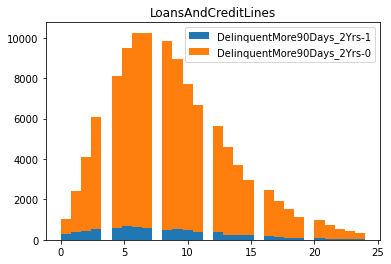

In [22]:
descriptive_graph(df,"LoansAndCreditLines")

And in order to have a normal distribution, logarithm is applied

In [23]:
df["LoansAndCreditLines"] = np.log(df["LoansAndCreditLines"]+1)

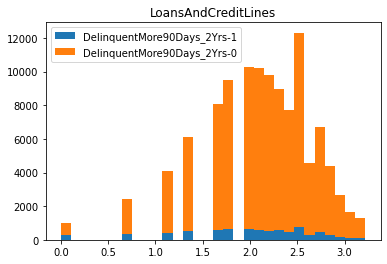

In [24]:
descriptive_graph(df,"LoansAndCreditLines")

**Days30-59LateNo2Y**

In [25]:
df["Days30-59LateNo2Y"].value_counts()
df["Days30-59LateNo2Y"].quantile(0.99)

4.0

excluding possible outliers

In [26]:
df = df[df["Days30-59LateNo2Y"]<4]

**Days60-89LateNo2Y**

In [27]:
df["Days30-59LateNo2Y"].value_counts()

0    92863
1    12632
2     3710
3     1429
Name: Days30-59LateNo2Y, dtype: int64

**Days90LateOrMore**

In [28]:
df["Days90LateOrMore"].value_counts()

0     104833
1       3809
2       1080
3        487
4        214
5         86
6         54
7         22
8         15
9         14
10         7
13         4
11         3
15         2
12         2
14         1
17         1
Name: Days90LateOrMore, dtype: int64

In [29]:
df = df[df["Days90LateOrMore"]<4]

**RealEstateLoans**

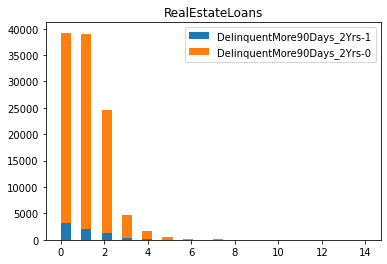

In [30]:
descriptive_graph(df,"RealEstateLoans")

In [31]:
df["RealEstateLoans"].quantile([.990])

0.99    4.0
Name: RealEstateLoans, dtype: float64

In [32]:
df = df[df["RealEstateLoans"] <= 4]

**FamilyMembers**

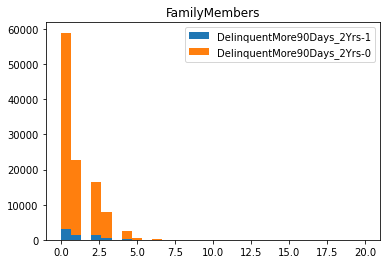

In [33]:
descriptive_graph(df,"FamilyMembers")

In [34]:
df["FamilyMembers"].quantile([.99])

0.99    4.0
Name: FamilyMembers, dtype: float64

In [35]:
df["FamilyMembers"].value_counts()

0.0     58976
1.0     22625
2.0     16539
3.0      7947
4.0      2395
5.0       610
6.0       132
7.0        44
8.0        20
9.0         4
10.0        4
13.0        1
20.0        1
Name: FamilyMembers, dtype: int64

all values more than 4 will be removed since it can interupt the results with its high value, even it is a possible scenario

In [36]:
df = df[df["FamilyMembers"] <= 4]

In general, FamilyMembers variables does not seem reasonable for prediction and can mislead the model which should be taken out of model

In [37]:
df = df.drop(columns=['FamilyMembers'], axis=1)

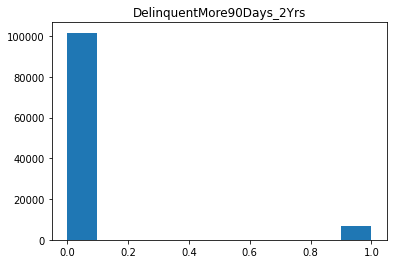

In [38]:
plt.hist(df["DelinquentMore90Days_2Yrs"])
plt.title("DelinquentMore90Days_2Yrs")
plt.show()

---
Clearly, classes are very inbalanced, so observations with value 0 overweights those who are with value 1. It can cause misleading results, so **accuracy** is not the best tool to use.
Missing a person who is delinquent can bring more issues than opposite prediction (predicting that a person will be delinquent, but it will not be).<br>
**Recall** = True Positive / (True Positive + False Negative) <br>
**Specificity** = True Negative / (True Negative + False Positive)<br>
**F1 score** = can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 <br>
**ROC and AUC** is a target measure to determine how good is discrimination
***
Resampling can be applied since only 6.22 percentages of data consist of value 1

In [39]:
len(df[df["DelinquentMore90Days_2Yrs"]==1])/len(df)

0.06229604911413875

#### Resample 
Oversamling, adding examples of minority class - can cause overfitting (random sampling)

Undersampling, removing samples from majority class - can cause loss of information (random sampling)

(Tomek links) for undersampling can be used where majority classes are removed where they are very closed to minority class

SMOTE (Synthetic Minority Oversampling Technique) for oversampling where it consist of randomly picking point from minority class and computing k-nearest neighbors for this point, so the data would be added between the chosen points and its neighbors

SMOTETomek is a combination of both Tomek and SMOTE which could be used for training data

## 3. Building and Selecting the Model

Splitting into 3 parts in order to check different model performances
- 70% train 
- 30% test

We do not need validation data, because we are using **cross validation**.

Since we do not have original test data, assuming test data is different dataset.

Models have different advantageous and disadvantage for instance:
#### Decision Tree
- Easy to Understand
- Easily Overfit
- Sensitive to changes in train data

#### Random Forest
- Can deal with overfitting
- Able to deal with large number of variables
- Takes longer to train

#### XGBoost
- Became very popular algorithm for classification (fast, effective, outliers do not have impact, good performance in Kaggle)
- Fastly handles big data sizes
- Harder to understand (a lot of hyperparameters)

Additionally, **Logistic Regression** is widely used for credit scoring, so by this case, all promising models will be tested in order to select the best

In [40]:
train, test = train_test_split(df,test_size=0.3)

In [41]:
X_test= test.drop(["DelinquentMore90Days_2Yrs"],axis=1)
Y_test = test["DelinquentMore90Days_2Yrs"]

In [42]:
X_unbalanced = train.drop(["DelinquentMore90Days_2Yrs"],axis=1)
Y_unbalanced = train["DelinquentMore90Days_2Yrs"]

In [43]:
smt = SMOTETomek(random_state=42)
X_balanced, Y_balanced = smt.fit_resample(X_unbalanced, Y_unbalanced)

In [44]:
print('Resampled dataset shape 0:',len(Y_balanced==0),' 1:',len(Y_balanced==1))

Resampled dataset shape 0: 140780  1: 140780


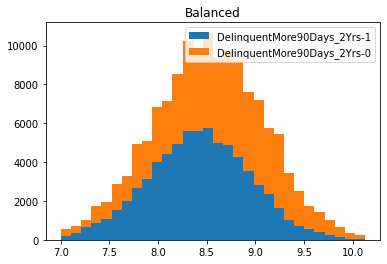

In [46]:
plt.hist([X_balanced[Y_balanced==1]['MonthlyIncome'],
X_balanced[Y_balanced==0]['MonthlyIncome']], bins=30, stacked=True)
plt.legend(labels=["DelinquentMore90Days_2Yrs-1","DelinquentMore90Days_2Yrs-0"])
plt.title('Balanced')
plt.show()

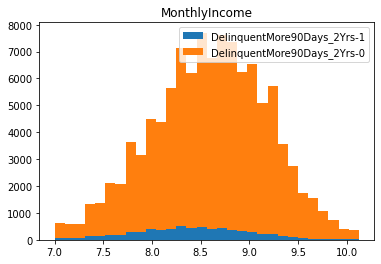

In [47]:
descriptive_graph(df,"MonthlyIncome")

As an example data is resampled successfully as distribution of both datasets are very similar so it can give assumption that other columns affected similary. <br>
Additionally, both datasets will be compared to check is resample helps

### Given Models

In [48]:
classifiers ={
    "LogisticRegression" : LogisticRegression(max_iter = 1000),
    "RandomForestClassifier" : RandomForestClassifier(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": tree.DecisionTreeClassifier(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Extreme Gradient Boosting": XGBClassifier()
}

In order to have better accuracy of the model (priority to avoid frauds) **roc_auc** is a good measure to select a model which can be updated by hyperparameters

In [49]:
print("Unbalanced Data----------------")
for key, clf in classifiers.items():
    start_time = time.time()
    score = cross_val_score(clf,X_unbalanced,Y_unbalanced,cv = 10,scoring='roc_auc')
    end_time = time.time() - start_time
    print(key,'score',round(score.mean(),2),'  Running Time', round(end_time,2))

Unbalanced Data----------------
LogisticRegression score 0.8   Running Time 13.35
RandomForestClassifier score 0.81   Running Time 143.66
KNearest score 0.69   Running Time 7.48
DecisionTreeClassifier score 0.59   Running Time 6.42
Stochastic Gradient Descent score 0.55   Running Time 3.3
Extreme Gradient Boosting score 0.84   Running Time 28.66


In [50]:
print("Balanced Data----------------")
for key, clf in classifiers.items():
    start_time = time.time()
    score = cross_val_score(clf,X_balanced,Y_balanced,cv = 10,scoring='roc_auc')
    end_time = time.time() - start_time
    print(key,'score',round(score.mean(),2),'  Running Time', round(end_time,2))

Balanced Data----------------
LogisticRegression score 0.78   Running Time 26.22
RandomForestClassifier score 0.98   Running Time 325.02
KNearest score 0.94   Running Time 14.09
DecisionTreeClassifier score 0.9   Running Time 10.37
Stochastic Gradient Descent score 0.74   Running Time 6.6
Extreme Gradient Boosting score 0.94   Running Time 59.16


For **balanced data**, **Extreme Gradient Boosting** is the best model <br>
For **unbalanced data**, **Random Forest Classifier** is the best model <br>
For balanced data, the reallity can give different scenarious since target data is unballanced. Since XGBBoost does not takes so much time, it can be used for balanced data as comparison

 ## 4. Performance of Model

Hyperparameters are not used since it is not the goal of this task

In [51]:
seleceted_model_unbalanced = XGBClassifier()

seleceted_model_unbalanced.fit(X_unbalanced,Y_unbalanced)

Y_test_predicted_un = seleceted_model_unbalanced.predict(X_test)

In [52]:
seleceted_model_balanced_xgboost = XGBClassifier()
seleceted_model_balanced_rFor = RandomForestClassifier()

seleceted_model_balanced_xgboost.fit(X_balanced,Y_balanced)
seleceted_model_balanced_rFor.fit(X_balanced,Y_balanced)

Y_test_predicted_bal_xgboost = seleceted_model_balanced_xgboost.predict(X_test)
Y_test_predicted_bal_rFor = seleceted_model_balanced_rFor.predict(X_test)

#### Cheking metrics of given models

In [53]:
false_positive_rate_un, true_positive_rate_un, thresholds = roc_curve(Y_test, seleceted_model_unbalanced.predict_proba(X_test)[:,1])

In [54]:
false_positive_rate_bal_xgboost, true_positive_rate_bal_xgboost, thresholds = roc_curve(Y_test, seleceted_model_balanced_xgboost.predict_proba(X_test)[:,1])
false_positive_rate_bal_rFor, true_positive_rate_bal_rFor, thresholds = roc_curve(Y_test, seleceted_model_balanced_rFor.predict_proba(X_test)[:,1])

In [55]:
print("Unbalanced-------")
print(pd.crosstab(np.array(Y_test), Y_test_predicted_un, rownames=['True'], colnames=['Predicted'], margins=True))
auc_score = auc(false_positive_rate_un, true_positive_rate_un)
print("")
print('recall_score: ',recall_score(Y_test, Y_test_predicted_un))
print('auc_score: ',auc_score)
print('F1 score: ',f1_score(Y_test, Y_test_predicted_un))

Unbalanced-------
Predicted      0    1    All
True                        
0          30331  166  30497
1           1795  253   2048
All        32126  419  32545

recall_score:  0.12353515625
auc_score:  0.8470342866075967
F1 score:  0.20510741791649778


In [56]:
print("Balanced-------XGBoost-------")
print(pd.crosstab(np.array(Y_test), Y_test_predicted_bal_xgboost, rownames=['True'], colnames=['Predicted'], margins=True))
auc_score_bal_xgboost = auc(false_positive_rate_bal_xgboost, true_positive_rate_bal_xgboost)
print("")
print('recall_score: ',recall_score(Y_test, Y_test_predicted_bal_xgboost))
print('auc_score: ',auc_score_bal_xgboost)
print('F1 score: ',f1_score(Y_test, Y_test_predicted_bal_xgboost))

print("")

print("Balanced-------Random Forest-------")
print(pd.crosstab(np.array(Y_test), Y_test_predicted_bal_rFor, rownames=['True'], colnames=['Predicted'], margins=True))
auc_score_bal_rFor = auc(false_positive_rate_bal_rFor, true_positive_rate_bal_rFor)
print("")
print('recall_score: ',recall_score(Y_test, Y_test_predicted_bal_rFor))
print('auc_score: ',auc_score_bal_rFor)
print('F1 score: ',f1_score(Y_test, Y_test_predicted_bal_rFor))

Balanced-------XGBoost-------
Predicted      0     1    All
True                         
0          25349  5148  30497
1            708  1340   2048
All        26057  6488  32545

recall_score:  0.654296875
auc_score:  0.8261683446194502
F1 score:  0.3139643861293346

Balanced-------Random Forest-------
Predicted      0     1    All
True                         
0          27882  2615  30497
1           1145   903   2048
All        29027  3518  32545

recall_score:  0.44091796875
auc_score:  0.801768835933145
F1 score:  0.3244699964067553


auc_score did not improve for balanced data, BUT recall_score increased a lot, which is very crucial part for given model (heavily depends on a mission). Balanced data is better for a model if we are focusing on recall_score, since auc_score did not reduced a lot and F1 score increased.<br> <br>
By comparing xgboost and random forest, xgboost is a better model which can be spotted since there could be a correlation between performance of models of unbalanced and balanced data. Since we used cross_validation, was harder to spot a performance for balanced data.

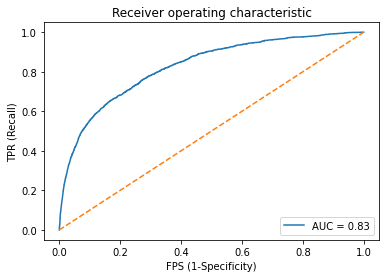

In [57]:
plt.title('Receiver operating characteristic')
plt.plot(false_positive_rate_bal_xgboost,true_positive_rate_bal_xgboost,label = 'AUC = %0.2f' % auc_score_bal_xgboost)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('TPR (Recall)')
plt.xlabel('FPS (1-Specificity)')
plt.show()

Usually a good model has AUC higher than 0.5, the bigger AUC plot is, the better model is. Since our models' AUC is 0.83 the classification model is good, but risky, depends how damageable is to miss a delinquent customer.

A model **can be improved** by applying:
- Scale data to have similar ranges of values
- Try not to remove missing MonthlyIncome rows, but to apply mean or add additional column where 1 gives a value for rows where data is missing or even to predict missing values
- Remove variables based on feature selection
- Grid Search to find the most optimal parameters (proper hyperparameters)
- Test other models as neural networks